Installing Requirements

In [1]:
!pip install transformers[sentencepiece] datasets sacrebleu rouge_score py7zr -q

DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: tensorflow-gpu 2.11.0 has a non-standard dependency specifier platform_system!="Darwin". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorflow-gpu or contact the author to suggest that they release a version with a con

In [2]:
from transformers import pipeline, set_seed

import matplotlib.pyplot as plt

import pandas as pd
from datasets import load_dataset, load_metric
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import sent_tokenize

nltk.download("punkt")

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

CNN/DailyMail Dataset

In [3]:
from datasets import load_dataset

dataset = load_dataset("cnn_dailymail", version="3.0.0")

print(f"Features in cnn_dailymail : {dataset['train'].column_names}")

Features in cnn_dailymail : ['article', 'highlights', 'id']


In [4]:
sample = dataset["train"][1]
print(f"""
Article (excerpt of 500 characters, total length: {len(sample["article"])}):
""")
print(sample["article"][:500])
print(f'\nSummary (length: {len(sample["highlights"])}):')
print(sample["highlights"])


Article (excerpt of 500 characters, total length: 4051):

Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most s

Summary (length: 281):
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .


Text Summarization Pipelines

In [5]:
sample_text = dataset["train"][1]["article"][:1000]

summaries = {}

Summarization Baseline

In [6]:
def baseline_summary_three_sent(text):
    return "\n".join(sent_tokenize(text)[:3])

In [7]:
summaries['baseline'] = baseline_summary_three_sent(sample_text)

summaries['baseline']

'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.\nHere, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.\nMIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."'

GPT-2

In [8]:
from transformers import pipeline, set_seed

set_seed(42)

pipe = pipeline('text-generation', model = 'gpt2-medium' )

gpt2_query = sample_text + "\nTL;DR:\n"

pipe_out = pipe(gpt2_query, max_length = 512, clean_up_tokenization_spaces = True)

Xformers is not installed correctly. If you want to use memory_efficient_attention to accelerate training use the following command to install Xformers
pip install xformers.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [9]:
pipe_out

[{'generated_text': 'Editor\'s note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events. Here, Soledad O\'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial. MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, they face drug charges or charges of assaulting an officer --charges that Judge Steven Leifman says are usually "avoidable felonies." He says the arrests often result from confrontations with police. Mentally ill people often won\'t do what they\'re told when police arrive on the scene -- confrontation seems to exacerbate their illness and they become more paranoid, delusional, and

In [10]:
pipe_out[0]["generated_text"][len(gpt2_query) :]

"The Eighth Amendment of the U.S. Constitution protects embody citizens' right to be free from arrest or imprisonment. For mentally ill individuals housed in jails like these, many of whom are mentally ill yet are never accused of violence or violence at all, arrest is the last resort.\nMentally ill individuals are placed on trial and often face charges of violence and violence at all times from detention officers. These charges can often result in death as long as evidence shows the officer acted negligently or otherwise failed to exercise reasonable force in his/her time assigned to the incident.\n(Taken from A Jail With Mental Illness That is No Otherplace In Prison, 2010.)\nPosted by Soledad O'Brien at 22:28"

In [11]:
summaries['gpt2'] = "\n".join(sent_tokenize(pipe_out[0]["generated_text"][len(gpt2_query) :]))

In [12]:
summaries['gpt2']

"The Eighth Amendment of the U.S. Constitution protects embody citizens' right to be free from arrest or imprisonment.\nFor mentally ill individuals housed in jails like these, many of whom are mentally ill yet are never accused of violence or violence at all, arrest is the last resort.\nMentally ill individuals are placed on trial and often face charges of violence and violence at all times from detention officers.\nThese charges can often result in death as long as evidence shows the officer acted negligently or otherwise failed to exercise reasonable force in his/her time assigned to the incident.\n(Taken from A Jail With Mental Illness That is No Otherplace In Prison, 2010.)\nPosted by Soledad O'Brien at 22:28"

T5

In [13]:
pipe = pipeline('summarization', model = 't5-small' )

pipe_out = pipe(sample_text)

In [14]:
pipe_out

[{'summary_text': "inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court . most often, they face drug charges or charges of assaulting an officer . mentally ill people become more paranoid, delusional, and less likely to follow dir ."}]

In [15]:
summaries['t5'] = 'n'.join(sent_tokenize(pipe_out[0]['summary_text']))

In [16]:
summaries['t5']

"inmates with the most severe mental illnesses are incarcerated until they're ready to appear in court .nmost often, they face drug charges or charges of assaulting an officer .nmentally ill people become more paranoid, delusional, and less likely to follow dir ."

Bart

In [17]:
pipe = pipeline("summarization", model="facebook/bart-large-cnn")
pipe_out = pipe(sample_text)

In [18]:
pipe_out

[{'summary_text': 'Miami-Dade pretrial detention facility is dubbed the "forgotten floor" Here, inmates with the most severe mental illnesses are incarcerated. Most often, they face drug charges or charges of assaulting an officer. Judge Steven Leifman says the arrests often result from confrontations with police.'}]

In [19]:
summaries["bart"] = "\n".join(sent_tokenize(pipe_out[0]["summary_text"]))

In [20]:
summaries["bart"]

'Miami-Dade pretrial detention facility is dubbed the "forgotten floor" Here, inmates with the most severe mental illnesses are incarcerated.\nMost often, they face drug charges or charges of assaulting an officer.\nJudge Steven Leifman says the arrests often result from confrontations with police.'

Pegasus

In [21]:
pipe = pipeline('summarization', model="google/pegasus-cnn_dailymail"  )

pipe_out = pipe(sample_text)

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
pipe_out

[{'summary_text': 'Mentally ill inmates are housed on the "forgotten floor" of a Miami jail .<n>Judge Steven Leifman says the charges are usually "avoidable felonies"<n>He says the arrests often result from confrontations with police .<n>Mentally ill people often won\'t do what they\'re told when police arrive on the scene .'}]

In [23]:
summaries["pegasus"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [24]:
summaries["pegasus"]

'Mentally ill inmates are housed on the "forgotten floor" of a Miami jail.\nJudge Steven Leifman says the charges are usually "avoidable felonies"<n>He says the arrests often result from confrontations with police.\nMentally ill people often won\'t do what they\'re told when police arrive on the scene .'

Mbart

In [25]:
pipe = pipeline("summarization", model="facebook/mbart-large-cc25")
pipe_out = pipe(sample_text)

Your max_length is set to 1024, but your input_length is only 247. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=123)


In [26]:
pipe_out

[{'summary_text': 'Editor\'Brien takes users inside a jail where many of the jail where many of the mentally, and mentally, and mentally, and mentally, mental, and to a jail. An inmates. An in a jail where a jail where the mentally ill. An in a jail where the mentally ill. An inmate before trial. An inmate. An inmate housed on the "forgotten floor." The Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, court.'}]

In [27]:
summaries["mbart"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [28]:
summaries["mbart"]

'Editor\'Brien takes users inside a jail where many of the jail where many of the mentally, and mentally, and mentally, and mentally, mental, and to a jail. An inmates. An in a jail where a jail where the mentally ill. An in a jail where the mentally ill. An inmate before trial. An inmate. An inmate housed on the "forgotten floor." The Miami-Dade pretrial detention facility is dubbed the "forgotten floor." Here, inmates with the most severe mental illnesses are incarcerated until they\'re ready to appear in court. Most often, court.'

MarianMT

In [29]:
pipe = pipeline("summarization", model="Helsinki-NLP/opus-mt-en-ro")
pipe_out = pipe(sample_text)

Your max_length is set to 512, but your input_length is only 243. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=121)


In [30]:
pipe_out

[{'summary_text': 'Nota editorului: În spatele serialului Scenes, corespondenţii CNN îşi împărtăşesc experienţele în acoperirea ştirilor şi analiza poveştilor din spatele evenimentelor. Aici, Soledad O\'Brien duce utilizatorii într-o închisoare în care mulţi dintre deţinuţi sunt bolnavi mintal. Un deţinut găzduit pe "etajul uitat," unde mulţi deţinuţi bolnavi mintal sunt închişi în Miami înainte de proces. MIAMI, Florida (CNN) -- Etajul 9 al unităţii de de detenţie prejudecată Miami-Dade este numit "etajul uitat." Aici, deţinuţii cu cele mai grave boli mentale sunt încarceraţi până când sunt gata să apară în instanţă. De cele mai multe ori, ei se confruntă cu acuzaţii de droguri sau acuzaţii de atac asupra unui ofiţer -- acuzaţiile pe care judecătorul Stevenif Leman le spune că sunt de obicei "falifii evitabili şi mai puţin probabili să le urmeze, paranoide şi mai puţin probabil să le urmeze.'}]

In [31]:
summaries["MarianMT"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [32]:
summaries["MarianMT"]

'Nota editorului: În spatele serialului Scenes, corespondenţii CNN îşi împărtăşesc experienţele în acoperirea ştirilor şi analiza poveştilor din spatele evenimentelor. Aici, Soledad O\'Brien duce utilizatorii într-o închisoare în care mulţi dintre deţinuţi sunt bolnavi mintal. Un deţinut găzduit pe "etajul uitat," unde mulţi deţinuţi bolnavi mintal sunt închişi în Miami înainte de proces. MIAMI, Florida (CNN) -- Etajul 9 al unităţii de de detenţie prejudecată Miami-Dade este numit "etajul uitat." Aici, deţinuţii cu cele mai grave boli mentale sunt încarceraţi până când sunt gata să apară în instanţă. De cele mai multe ori, ei se confruntă cu acuzaţii de droguri sau acuzaţii de atac asupra unui ofiţer -- acuzaţiile pe care judecătorul Stevenif Leman le spune că sunt de obicei "falifii evitabili şi mai puţin probabili să le urmeze, paranoide şi mai puţin probabil să le urmeze.'

Prophetnet

In [33]:
pipe = pipeline("summarization", model="microsoft/prophetnet-large-uncased")
pipe_out = pipe(sample_text)

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [34]:
pipe_out

[{'summary_text': 'behind - the - scenes behind the scenes'}]

In [35]:
summaries["prophetnet"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [36]:
summaries["prophetnet"]

'behind - the - scenes behind the scenes'

FSMT

In [37]:
pipe = pipeline("summarization", model="facebook/wmt19-en-de")
pipe_out = pipe(sample_text)

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-de and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
pipe_out

[{'summary_text': 'Anmerkung der Redaktion: In unserer Serie Hinter den Kulissen berichten CNN-Korrespondenten über ihre Erfahrungen bei der Berichterstattung und analysieren die Geschichten hinter den Ereignissen. Hier führt Soledad O \'Brien Benutzer in ein Gefängnis, in dem viele der Insassen psychisch krank sind. Ein Häftling, der im "vergessenen Fußboden" untergebracht ist, wo viele psychisch kranke Insassen vor dem Prozess in Miami untergebracht sind. MIAMI, Florida (CNN) -- Der neunte Stock des Untersuchungsgefängnisses in Miami-Dade wird als "vergessener Fußboden" bezeichnet. Hier werden Insassen mit den schwersten psychischen Krankheiten eingesperrt, bis sie bereit sind, vor Gericht zu erscheinen. Meistens werden sie wegen Drogendelikten oder tätlichen Angriffs auf einen Beamten angeklagt - Anklagen, die Richter Steven Leifman für gewöhnlich als "vermeidbare Verbrechen" bezeichnet. Er sagt, dass die Verhaft'}]

In [39]:
summaries["FSMT"] = pipe_out[0]["summary_text"].replace(" .<n>", ".\n")

In [40]:
summaries["FSMT"]

'Anmerkung der Redaktion: In unserer Serie Hinter den Kulissen berichten CNN-Korrespondenten über ihre Erfahrungen bei der Berichterstattung und analysieren die Geschichten hinter den Ereignissen. Hier führt Soledad O \'Brien Benutzer in ein Gefängnis, in dem viele der Insassen psychisch krank sind. Ein Häftling, der im "vergessenen Fußboden" untergebracht ist, wo viele psychisch kranke Insassen vor dem Prozess in Miami untergebracht sind. MIAMI, Florida (CNN) -- Der neunte Stock des Untersuchungsgefängnisses in Miami-Dade wird als "vergessener Fußboden" bezeichnet. Hier werden Insassen mit den schwersten psychischen Krankheiten eingesperrt, bis sie bereit sind, vor Gericht zu erscheinen. Meistens werden sie wegen Drogendelikten oder tätlichen Angriffs auf einen Beamten angeklagt - Anklagen, die Richter Steven Leifman für gewöhnlich als "vermeidbare Verbrechen" bezeichnet. Er sagt, dass die Verhaft'

Comparing Different Summaries

In [41]:
print("GROUND TRUTH")

print(dataset['train'][1]['highlights'])

for model_name in summaries:
    print(model_name.upper())
    print(summaries[model_name])

GROUND TRUTH
Mentally ill inmates in Miami are housed on the "forgotten floor"
Judge Steven Leifman says most are there as a result of "avoidable felonies"
While CNN tours facility, patient shouts: "I am the son of the president"
Leifman says the system is unjust and he's fighting for change .
BASELINE
Editor's note: In our Behind the Scenes series, CNN correspondents share their experiences in covering news and analyze the stories behind the events.
Here, Soledad O'Brien takes users inside a jail where many of the inmates are mentally ill. An inmate housed on the "forgotten floor," where many mentally ill inmates are housed in Miami before trial.
MIAMI, Florida (CNN) -- The ninth floor of the Miami-Dade pretrial detention facility is dubbed the "forgotten floor."
GPT2
The Eighth Amendment of the U.S. Constitution protects embody citizens' right to be free from arrest or imprisonment.
For mentally ill individuals housed in jails like these, many of whom are mentally ill yet are never a

SacreBLEU

In [42]:
from datasets import load_metric

bleu_metric = load_metric("sacrebleu")

<ipython-input-42-eacc06f6d0e4>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric("sacrebleu")


In [43]:
bleu_metric.add(prediction = [summaries["pegasus"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,18.73841
counts,"[27, 14, 10, 6]"
totals,"[67, 66, 65, 64]"
precisions,"[40.298507462686565, 21.21212121212121, 15.384..."
bp,1.0
sys_len,67
ref_len,57
precision,"[40.3, 21.21, 15.38, 9.38]"


In [44]:
bleu_metric.add(prediction = [summaries["bart"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,10.887081
counts,"[19, 7, 5, 2]"
totals,"[55, 54, 53, 52]"
precisions,"[34.54545454545455, 12.962962962962964, 9.4339..."
bp,0.96429
sys_len,55
ref_len,57
precision,"[34.55, 12.96, 9.43, 3.85]"


In [45]:
bleu_metric.add(prediction = [summaries["t5"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,0.0
counts,"[12, 0, 0, 0]"
totals,"[51, 50, 49, 48]"
precisions,"[23.529411764705884, 0.0, 0.0, 0.0]"
bp,0.88901
sys_len,51
ref_len,57
precision,"[23.53, 0.0, 0.0, 0.0]"


In [46]:
bleu_metric.add(prediction = [summaries["gpt2"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,0.0
counts,"[21, 1, 0, 0]"
totals,"[146, 145, 144, 143]"
precisions,"[14.383561643835616, 0.6896551724137931, 0.0, ..."
bp,1.0
sys_len,146
ref_len,57
precision,"[14.38, 0.69, 0.0, 0.0]"


In [47]:
bleu_metric.add(prediction = [summaries["mbart"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,5.543703
counts,"[25, 6, 4, 3]"
totals,"[119, 118, 117, 116]"
precisions,"[21.008403361344538, 5.084745762711864, 3.4188..."
bp,1.0
sys_len,119
ref_len,57
precision,"[21.01, 5.08, 3.42, 2.59]"


In [48]:
bleu_metric.add(prediction = [summaries["MarianMT"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,0.0
counts,"[10, 0, 0, 0]"
totals,"[163, 162, 161, 160]"
precisions,"[6.134969325153374, 0.0, 0.0, 0.0]"
bp,1.0
sys_len,163
ref_len,57
precision,"[6.13, 0.0, 0.0, 0.0]"


In [49]:
bleu_metric.add(prediction = [summaries["prophetnet"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,0.0
counts,"[2, 0, 0, 0]"
totals,"[10, 9, 8, 7]"
precisions,"[20.0, 0.0, 0.0, 0.0]"
bp,0.009095
sys_len,10
ref_len,57
precision,"[20.0, 0.0, 0.0, 0.0]"


In [50]:
bleu_metric.add(prediction = [summaries["FSMT"]], reference = [dataset['train'][1]['highlights'] ])

results = bleu_metric.compute(smooth_method = 'floor', smooth_value = 0 )

results['precision'] = [np.round(p , 2) for p in results['precisions'] ]

pd.DataFrame.from_dict(results, orient = 'index', columns = ['Value'] )

,Value
score,0.0
counts,"[14, 2, 0, 0]"
totals,"[149, 148, 147, 146]"
precisions,"[9.395973154362416, 1.3513513513513513, 0.0, 0.0]"
bp,1.0
sys_len,149
ref_len,57
precision,"[9.4, 1.35, 0.0, 0.0]"


ROUGE

In [51]:
rouge_metric = load_metric('rouge')

In [52]:
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]

reference = dataset['train'][1]['highlights']

records = []

for model_name in summaries:
    rouge_metric.add(prediction = summaries[model_name], reference = reference )
    score = rouge_metric.compute()
    rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )
    print('rouge_dict ', rouge_dict )
    records.append(rouge_dict)

pd.DataFrame.from_records(records, index = summaries.keys() )

rouge_dict  {'rouge1': 0.365079365079365, 'rouge2': 0.14516129032258066, 'rougeL': 0.20634920634920634, 'rougeLsum': 0.2857142857142857}
rouge_dict  {'rouge1': 0.23255813953488372, 'rouge2': 0.023529411764705885, 'rougeL': 0.12790697674418605, 'rougeLsum': 0.19767441860465115}
rouge_dict  {'rouge1': 0.1758241758241758, 'rouge2': 0.0, 'rougeL': 0.13186813186813187, 'rougeLsum': 0.15384615384615383}
rouge_dict  {'rouge1': 0.3655913978494624, 'rouge2': 0.13186813186813184, 'rougeL': 0.2150537634408602, 'rougeLsum': 0.3225806451612903}
rouge_dict  {'rouge1': 0.5, 'rouge2': 0.24489795918367346, 'rougeL': 0.36000000000000004, 'rougeLsum': 0.46}
rouge_dict  {'rouge1': 0.2937062937062937, 'rouge2': 0.0851063829787234, 'rougeL': 0.15384615384615383, 'rougeLsum': 0.2097902097902098}
rouge_dict  {'rouge1': 0.04651162790697675, 'rouge2': 0.0, 'rougeL': 0.037209302325581395, 'rougeLsum': 0.037209302325581395}
rouge_dict  {'rouge1': 0.07272727272727272, 'rouge2': 0.0, 'rougeL': 0.07272727272727272, 

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.365079,0.145161,0.206349,0.285714
gpt2,0.232558,0.023529,0.127907,0.197674
t5,0.175824,0.000000,0.131868,0.153846
bart,0.365591,0.131868,0.215054,0.322581
pegasus,0.500000,0.244898,0.360000,0.460000
mbart,0.293706,0.085106,0.153846,0.209790
MarianMT,0.046512,0.000000,0.037209,0.037209
prophetnet,0.072727,0.000000,0.072727,0.072727
FSMT,0.055249,0.022346,0.044199,0.055249


Evaluationg on the TEST set of the CNN/DailyMail Dataset

In [53]:
def calculate_metric_on_baseline_test_ds(dataset, metric, column_text = 'article', column_summary = 'highlights' ):
  
    summaries = [baseline_summary_three_sent(text) for text in dataset[column_text] ]

    metric.add_batch(predictions = summaries, references = dataset[column_summary] )

    score = metric.compute()
    return score

In [54]:
score

{'rouge1': AggregateScore(low=Score(precision=0.03787878787878788, recall=0.10204081632653061, fmeasure=0.05524861878453039), mid=Score(precision=0.03787878787878788, recall=0.10204081632653061, fmeasure=0.05524861878453039), high=Score(precision=0.03787878787878788, recall=0.10204081632653061, fmeasure=0.05524861878453039)),
 'rouge2': AggregateScore(low=Score(precision=0.015267175572519083, recall=0.041666666666666664, fmeasure=0.0223463687150838), mid=Score(precision=0.015267175572519083, recall=0.041666666666666664, fmeasure=0.0223463687150838), high=Score(precision=0.015267175572519083, recall=0.041666666666666664, fmeasure=0.0223463687150838)),
 'rougeL': AggregateScore(low=Score(precision=0.030303030303030304, recall=0.08163265306122448, fmeasure=0.04419889502762431), mid=Score(precision=0.030303030303030304, recall=0.08163265306122448, fmeasure=0.04419889502762431), high=Score(precision=0.030303030303030304, recall=0.08163265306122448, fmeasure=0.04419889502762431)),
 'rougeLsu

In [55]:
test_sampled = dataset['train'].shuffle(seed = 42).select(range(1000))

score = calculate_metric_on_baseline_test_ds(test_sampled, rouge_metric )

rouge_dict = dict((rn, score[rn].mid.fmeasure ) for rn in rouge_names )

pd.DataFrame.from_dict(rouge_dict, orient = 'index' , columns = ['baseline'] ).T

,rouge1,rouge2,rougeL,rougeLsum
baseline,0.253995,0.100642,0.165754,0.231571


ROUGE Metric on test dataset for the other Models

In [56]:
from tqdm import tqdm
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

def generate_batch_sized_chunks(list_of_elements, batch_size):
    for i in range(0, len(list_of_elements), batch_size):
        yield list_of_elements[i : i + batch_size]

def calculate_metric_on_test_ds(dataset, metric, model, tokenizer,
                               batch_size=16, device=device,
                               column_text="article",
                               column_summary="highlights"):

    article_batches = list(generate_batch_sized_chunks(dataset[column_text], batch_size))
    target_batches = list(generate_batch_sized_chunks(dataset[column_summary], batch_size))

    for article_batch, target_batch in tqdm(
        zip(article_batches, target_batches), total=len(article_batches)):

        inputs = tokenizer(article_batch, max_length=1024,  truncation=True,
                        padding="max_length", return_tensors="pt")

        summaries = model.generate(input_ids=inputs["input_ids"].to(device),
                         attention_mask=inputs["attention_mask"].to(device),
                         length_penalty=0.8, num_beams=8, max_length=128)
        decoded_summaries = [tokenizer.decode(s, skip_special_tokens=True,
                                clean_up_tokenization_spaces=True)
               for s in summaries]

        decoded_summaries = [d.replace("<n>", " ") for d in decoded_summaries]


        metric.add_batch(predictions=decoded_summaries, references=target_batch)

    score = metric.compute()
    return score

In [57]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

model_ckpt = "facebook/bart-large-cnn"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_bart = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric,
                                   model_bart, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["bart"])

100%|██████████| 125/125 [08:39<00:00,  4.15s/it]


,rouge1,rouge2,rougeL,rougeLsum
bart,0.409186,0.194755,0.296056,0.354099


In [58]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

model_ckpt = "google/pegasus-cnn_dailymail"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

model_pegasus = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric,
                                   model_pegasus, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

# At the end, we compute and return the ROUGE scores.
pd.DataFrame(rouge_dict, index=["pegasus"])

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-cnn_dailymail and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 125/125 [10:42<00:00,  5.14s/it]


,rouge1,rouge2,rougeL,rougeLsum
pegasus,0.47519,0.278492,0.373879,0.428834


In [59]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

model_ckpt = "t5-small"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_t5 = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric,
                                   model_t5, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

# At the end, we compute and return the ROUGE scores.
pd.DataFrame(rouge_dict, index=["t5"])

100%|██████████| 125/125 [04:31<00:00,  2.17s/it]


,rouge1,rouge2,rougeL,rougeLsum
t5,0.321486,0.132988,0.225468,0.279677


In [60]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

model_ckpt = "facebook/mbart-large-cc25"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_mbart = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric,
                                   model_mbart, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["mbart"])

100%|██████████| 125/125 [09:50<00:00,  4.73s/it]


,rouge1,rouge2,rougeL,rougeLsum
mbart,0.123014,0.031581,0.086183,0.106739


In [61]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

model_ckpt = "Helsinki-NLP/opus-mt-en-ro"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_MarianMT = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric,
                                   model_MarianMT, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["MarianMT"])

  0%|          | 0/125 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [64]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

model_ckpt = "microsoft/prophetnet-large-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_prophetnet = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric,
                                   model_prophetnet, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["prophetnet"])

/home/ubuntu/.local/lib/python3.8/site-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [63]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import pandas as pd

model_ckpt = "facebook/wmt19-en-de"

tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
device = "cuda" if torch.cuda.is_available() else "cpu"

model_FSMT = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt).to(device)

score = calculate_metric_on_test_ds(test_sampled, rouge_metric,
                                   model_FSMT, tokenizer, batch_size=8)

rouge_dict = dict((rn, score[rn].mid.fmeasure) for rn in rouge_names)

pd.DataFrame(rouge_dict, index=["FSMT"])

Some weights of FSMTForConditionalGeneration were not initialized from the model checkpoint at facebook/wmt19-en-de and are newly initialized: ['model.encoder.embed_positions.weight', 'model.decoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Visualizing performance of different models

In [65]:
pip install matplotlib numpy

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.36ubuntu1 has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: tensorflow-gpu 2.11.0 has a non-standard dependency specifier platform_system!="Darwin". pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of tensorfl

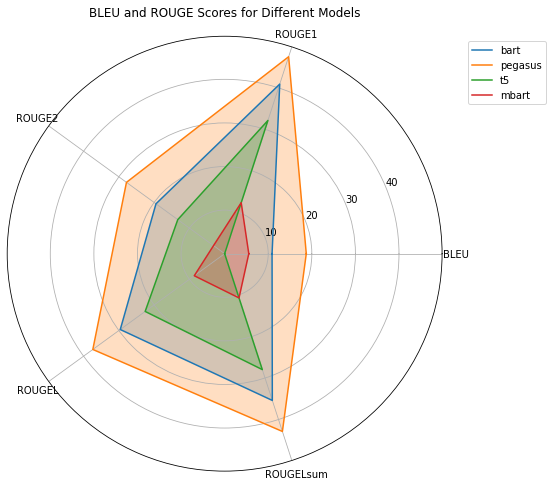

In [66]:
import numpy as np
import matplotlib.pyplot as plt

models = ['bart', 'pegasus', 't5', 'mbart']
bleu_scores = {'bart': 10.88, 'pegasus': 18.73, 't5': 0.0, 'mbart': 5.54}
rouge_scores_1 = {'bart': 40.91, 'pegasus': 47.51, 't5': 32.14, 'mbart': 12.30}
rouge_scores_2 = {'bart': 19.47, 'pegasus': 27.84, 't5': 13.29, 'mbart': 3.15}
rouge_scores_L = {'bart': 29.60, 'pegasus': 37.38, 't5': 22.54, 'mbart': 8.61}
rouge_scores_Lsum = {'bart': 35.40, 'pegasus': 42.88, 't5': 27.96, 'mbart': 10.67}

def create_radar_plot(models, bleu_scores, rouge_scores_1, rouge_scores_2, rouge_scores_L, rouge_scores_Lsum):
    categories = ['BLEU', 'ROUGE1', 'ROUGE2', 'ROUGEL', 'ROUGELsum']
    num_models = len(models)

    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False)

    angles = np.concatenate((angles, [angles[0]]))

    plt.figure(figsize=(8, 8))
    for model_idx, model in enumerate(models):
        bleu_score = bleu_scores[model]
        rouge_score_1 = rouge_scores_1[model]
        rouge_score_2 = rouge_scores_2[model]
        rouge_score_L = rouge_scores_L[model]
        rouge_score_Lsum = rouge_scores_Lsum[model]
        scores = [bleu_score, rouge_score_1, rouge_score_2, rouge_score_L, rouge_score_Lsum]
        scores = np.concatenate((scores, [scores[0]]))
        plt.polar(angles, scores, label=model)
        plt.fill(angles, scores, alpha=0.25)

    plt.xticks(angles[:-1], categories)

    plt.title('BLEU and ROUGE Scores for Different Models', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.25, 1))
    plt.show()

create_radar_plot(models, bleu_scores, rouge_scores_1, rouge_scores_2, rouge_scores_L, rouge_scores_Lsum)

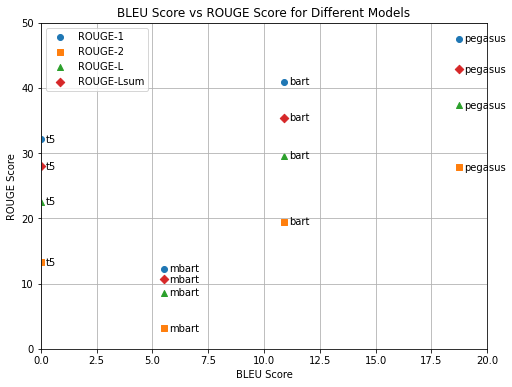

In [67]:
import matplotlib.pyplot as plt

models = ['bart', 'pegasus', 't5', 'mbart']
bleu_scores = {'bart': 10.88, 'pegasus': 18.73, 't5': 0.0, 'mbart': 5.54}
rouge_scores_1 = {'bart': 40.91, 'pegasus': 47.51, 't5': 32.14, 'mbart': 12.30}
rouge_scores_2 = {'bart': 19.47, 'pegasus': 27.84, 't5': 13.29, 'mbart': 3.15}
rouge_scores_L = {'bart': 29.60, 'pegasus': 37.38, 't5': 22.54, 'mbart': 8.61}
rouge_scores_Lsum = {'bart': 35.40, 'pegasus': 42.88, 't5': 27.96, 'mbart': 10.67}

def create_scatter_plot(models, bleu_scores, rouge_scores_1, rouge_scores_2, rouge_scores_L, rouge_scores_Lsum):
    plt.figure(figsize=(8, 6))

    # Create scatter plots for each model separately
    plt.scatter(bleu_scores.values(), rouge_scores_1.values(), label='ROUGE-1', marker='o')
    plt.scatter(bleu_scores.values(), rouge_scores_2.values(), label='ROUGE-2', marker='s')
    plt.scatter(bleu_scores.values(), rouge_scores_L.values(), label='ROUGE-L', marker='^')
    plt.scatter(bleu_scores.values(), rouge_scores_Lsum.values(), label='ROUGE-Lsum', marker='D')

    for model, bleu_score in bleu_scores.items():
        plt.annotate(model, xy=(bleu_score, rouge_scores_1[model]), xytext=(5, 0),
                     textcoords='offset points', ha='left', va='center')
        plt.annotate(model, xy=(bleu_score, rouge_scores_2[model]), xytext=(5, 0),
                     textcoords='offset points', ha='left', va='center')
        plt.annotate(model, xy=(bleu_score, rouge_scores_L[model]), xytext=(5, 0),
                     textcoords='offset points', ha='left', va='center')
        plt.annotate(model, xy=(bleu_score, rouge_scores_Lsum[model]), xytext=(5, 0),
                     textcoords='offset points', ha='left', va='center')

    plt.xlabel('BLEU Score')
    plt.ylabel('ROUGE Score')
    plt.title('BLEU Score vs ROUGE Score for Different Models')

    plt.xlim(0.0, 20.0)
    plt.ylim(0.0, 50.0)

    plt.legend()

    plt.grid()
    plt.show()

create_scatter_plot(models, bleu_scores, rouge_scores_1, rouge_scores_2, rouge_scores_L, rouge_scores_Lsum)
